# Compile the main simulator code using cython 

In [1]:
!python ../setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_plasticity.cpython-38-darwin.so -> 
running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_stop_signal.cpython-38-darwin.so -> 
/Users/cristina/Desktop/CBGTpy_sonoma/CBGTPy/notebooks/agent_timestep_stop_signal.cpython-38-darwin.so
/Users/cristina/Desktop/CBGTpy_sonoma/CBGTPy/notebooks/agent_timestep_plasticity.cpython-38-darwin.so


# Import all the relevant files 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import pathos.multiprocessing

In [3]:
import sys
sys.path.append('../')

#Importing scripts:

#Import relevant frames:
import common.cbgt as cbgt
import common.pipeline_creation as pl_creat

#Import plotting functions:
import common.plotting_functions as plt_func
import common.plotting_helper_functions as plt_help
import common.postprocessing_helpers as post_help

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

Choose the experiment to run, and define the number of choices, the number of simulations/thread to run and number of cores:

In [4]:
#Choose the experiment:
experiment_choice = 'stop-signal'

if experiment_choice == 'stop-signal':
    import stopsignal.paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import nchoice.paramfile_nchoice as paramfile

number_of_choices = 2

#Choose which multiprocessing library to use:
use_library = "none" # "none" or "pathos" or "ray"


# how many simulations do you want to run? each simulation is executed as a separate thread.
num_sims = 1
num_cores = 7


#Call choose_pipeline with the pipeline object:
pl_creat.choose_pipeline(experiment_choice)
#Create the main pipeline:
pl = pl_creat.create_main_pipeline(runloop=True)

#Set a seed:
seed = np.random.randint(0,99999999,1)[0]
print(seed)

in choose pipeline
in reward pipeline
75434668


Define data and figures directories:

In [5]:
data_dir = "../Data/"
figure_dir = "../Figures/"

# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [6]:
# list out the available parameter dictionaries:
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [ ]:
# view (or edit) one of the parameter dictionaries:
paramfile.celldefaults

### To change a parameter, simply assign the desired value to the parameter
### eg. paramfile.celldefaults['C'] = 0.5

In [ ]:
# paramfile.celldefaults['C'] = 0.5

# Running the pipeline

### Define configuration parameter

In [9]:
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None,
    'thalamic_threshold': 30.,
    'movement_time': ['mean', 250], #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout': 300,
    
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([['left'], ['right']], columns=['action']), #action channels related parameters
    'number_of_choices': number_of_choices,
    'newpathways' : None,     #connectivity parameters
    'Q_support_params': None, #initialization of Q-values update
    'Q_df_set': pd.DataFrame([[0.5, 0.5]],columns=["left", "right"]), #initialized Q-values df  
    'n_trials': 10,            #number of trials
    'volatility': [None,"exact"], #frequency of changepoints
    'conflict': (0.75, 0.25),         #probability of the preferred choice
    'reward_mu': 1,               #mean for the magnitude of the reward
    'reward_std': 0.1,            #std for the magnitude of the reward
    'maxstim': 0.85,  #0.85             #amplitude of the cortical input over base line
    'sustainedfraction': 0.75,
    
    #Stop signal
    'stop_signal_present': [False, False, False],
    'stop_signal_probability': [1., 1., 1.],  #probability of trials that will get the stop-signal / list of trial numbers
    'stop_signal_amplitude': [0.4, 0.4, 0.4],  #amplitude of the stop signal over base line
    'stop_signal_onset': [70.,70., 70.],       #in ms
    'stop_signal_duration' : [145.,145., 145.], 
    'stop_signal_channel': ["all","all", "all"], #"all" (all channels are given the stop signal) 
                                            #"any" (channel given the stop signal is chosen randomly)
                                            # [list of channels] == subset of channels given the stop signal
    'stop_signal_population':["STN","GPeA", "iSPN"],
    
    'record_variables':["weight", "stop_input"],
    
    
    #Opto signal
    'opt_signal_present': [False],
    'opt_signal_probability': [1.], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude': [.8],   #amplitude of the stop signal over base line
    'opt_signal_onset': [0.],      #in ms
    'opt_signal_duration': [150.],
    'opt_signal_channel': ["all"],  # "all" (all channels are given the stop signal) 
                                    #"any" (channel given the stop signal is chosen randomly)
                                    # [list of channels] == subset of channels given the stop signal
    
    'opt_signal_population':["Th"],
}

### Run the simulation

ExecutionManager class can take for 'use': 

- 'none', that corresponds to the singlethreaded mode;
- 'pathos', that corresponds to python's multiprocessing mode;
- 'ray', that corresponds to a multiprocessing library for python that operates on a client-server mode.

The default value is None (singlethreaded mode).

In [10]:
results = cbgt.ExecutionManager(cores=num_cores,use=use_library).run([pl]*num_sims,[configuration]*num_sims)

in choose pipeline
SpawnThreadManagers <common.backend.Pipeline object at 0x7fea29531940>
scaling_conn 1.0
scaling_wts 1
SpawnThreadManagers <common.backend.Pipeline object at 0x7fea2953b070>
SpawnThreadManagers <common.backend.Pipeline object at 0x7fea2953ba90>
scaling_conn 1.0
scaling_wts 1
SpawnThreadManagers <common.backend.Pipeline object at 0x7fea29511610>
gateFRs [26.66666667 30.66666667]
thresholds_crossed [1]
trial_num 0
chosen_action: right
gateFRs [19.55555556 30.66666667]
thresholds_crossed [1]
trial_num 1
chosen_action: right
gateFRs [30.22222222 27.55555556]
thresholds_crossed [0]
trial_num 2
chosen_action: left
gateFRs [30.22222222 27.77777778]
thresholds_crossed [0]
trial_num 3
chosen_action: left
gateFRs [23.55555556 31.55555556]
thresholds_crossed [1]
trial_num 4
chosen_action: right
gateFRs [26.22222222 26.        ]
thresholds_crossed []
trial_num 5
chosen_action: none
gateFRs [18.22222222 30.22222222]
thresholds_crossed [1]
trial_num 6
chosen_action: right
gateFRs [

# Results

List all the agent variables accessible: 

In [11]:
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_duration', 'stop_signal_channel', 'stop_signal_population', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'par', 'popconstruct', 'interface', 'gen_stop', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', '

In [12]:
results[0]['interface']

<module 'stopsignal.interface_stopsignal' from '/Users/cristina/Desktop/CBGTpy_sonoma/CBGTPy/notebooks/../stopsignal/interface_stopsignal.py'>

In [13]:
results[0]['stop_list_trials_list']

[array([4, 5, 6, 3, 7, 9, 2, 0, 8, 1]),
 array([5, 6, 9, 4, 0, 3, 2, 8, 1, 7]),
 array([1, 0, 3, 9, 7, 2, 5, 6, 8, 4])]

In [14]:
results[0]['meaneff_GABA']

,GPi,GPi,STN,STN,GPeP,GPeP,GPeA,GPeA,dSPN,dSPN,iSPN,iSPN,Cx,Cx,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPeP,0.058`,0.0`,0.37`,0.0`,0.45`,0.45`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeP,0.0`,0.058`,0.0`,0.37`,0.45`,0.45`,0.0`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.0`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
dSPN,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,0.0`,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [15]:
results[0]['stop_signal_amplitude']

[0.4, 0.4, 0.4]

In [16]:
results[0]['popdata']

,name,action,N,C,Taum,RestPot,ResetPot,Threshold,RestPot_ca,Alpha_ca,...,dpmn_APOST,dpmn_XPRE,dpmn_XPOST,dpmn_type,dpmn_alphaw,dpmn_wmax,dpmn_a,dpmn_b,dpmn_c,column
0,GPi`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,0
1,GPi`,right`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,1
2,STN`,left`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,2
3,STN`,right`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,3
4,GPeP`,left`,560`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,4
5,GPeP`,right`,560`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,5
6,GPeA`,left`,190`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,6
7,GPeA`,right`,190`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,7
8,dSPN`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,1`,55.0`,0.06`,1.0`,0.1`,0.05`,8
9,dSPN`,right`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,1`,55.0`,0.06`,1.0`,0.1`,0.05`,9


In [17]:
experiment_choice

'stop-signal'

Extract all the relevant dataframes:

In [18]:
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [19]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPeP_left,GPeP_right,GPeA_left,GPeA_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,75.777778,80.888889,23.177778,25.577778,57.470238,52.261905,5.263158,7.105263,2.444444,2.444444,2.444444,3.777778,0.000000,0.000000,4.222222,4.888889,7.777778,0.985663,0
1,76.888889,81.333333,22.911111,25.577778,57.380952,52.351190,5.350877,6.929825,2.444444,2.444444,2.444444,3.777778,0.000000,0.000000,4.222222,5.111111,8.000000,1.075269,1
2,76.000000,81.111111,23.088889,25.488889,57.470238,52.440476,5.350877,6.842105,2.444444,2.444444,2.444444,3.777778,0.000000,0.000000,4.222222,5.111111,7.777778,1.075269,2
3,76.000000,80.666667,23.022222,25.444444,57.202381,52.648810,5.438596,6.666667,2.444444,2.444444,2.444444,3.777778,0.000000,0.000000,3.777778,5.111111,7.333333,1.075269,3
4,76.222222,80.444444,23.088889,25.355556,57.202381,52.708333,5.350877,6.754386,2.444444,2.666667,2.444444,3.777778,0.000000,0.000000,3.777778,4.666667,7.555556,1.164875,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10406,74.222222,72.444444,25.266667,25.400000,56.428571,49.107143,6.228070,4.824561,4.000000,6.444444,4.888889,5.555556,3.676471,3.758170,6.000000,8.222222,8.444444,2.598566,10406
10407,73.111111,72.222222,24.977778,25.555556,57.291667,48.452381,6.140351,4.824561,4.000000,6.222222,4.888889,5.555556,3.758170,3.676471,6.222222,8.444444,8.000000,2.598566,10407
10408,75.333333,72.222222,24.555556,25.711111,57.321429,48.511905,6.052632,5.000000,3.555556,6.222222,5.111111,5.555556,3.839869,3.676471,6.222222,8.666667,8.222222,2.598566,10408
10409,73.777778,72.888889,24.777778,26.200000,57.232143,48.035714,6.052632,5.087719,3.555556,6.222222,5.333333,5.777778,3.758170,3.758170,6.222222,8.888889,8.000000,2.598566,10409


In [20]:
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed
0,0,GPi_left,75.777778,GPi,left,75434668_0
1,1,GPi_left,76.888889,GPi,left,75434668_0
2,2,GPi_left,76.000000,GPi,left,75434668_0
3,3,GPi_left,76.000000,GPi,left,75434668_0
4,4,GPi_left,76.222222,GPi,left,75434668_0
...,...,...,...,...,...,...
187393,10406,CxI_common,2.598566,CxI,common,75434668_0
187394,10407,CxI_common,2.598566,CxI,common,75434668_0
187395,10408,CxI_common,2.598566,CxI,common,75434668_0
187396,10409,CxI_common,2.598566,CxI,common,75434668_0


In [21]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['left' 'right']
nuc_list ['dSPN-left' 'iSPN-left' 'dSPN-right' 'iSPN-right']
ind_list [[0 0 1 0]
 [0 1 1 1]]


In [22]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.022,0,dSPN-left,75434668_0
1,0.022,1,dSPN-left,75434668_0
2,0.022,2,dSPN-left,75434668_0
3,0.022,3,dSPN-left,75434668_0
4,0.022,4,dSPN-left,75434668_0
5,0.022,5,dSPN-left,75434668_0
6,0.022,6,dSPN-left,75434668_0
7,0.022,7,dSPN-left,75434668_0
8,0.022,8,dSPN-left,75434668_0
0,0.022,0,iSPN-left,75434668_0


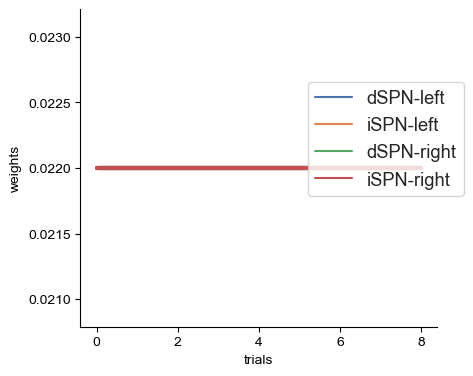

In [23]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(x="trials",y="weights",data=recorded_variables['weight'],hue='nuclei',lw=3.0,ax=ax)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right',bbox_to_anchor=[1.1, 0.8])
plt.tight_layout()
fig.savefig(figure_dir+'weight.png')

In [24]:
recorded_variables["stop_input"].nuclei.unique()#.melt(id_vars='Time(ms)')

array(['STN-left', 'STN-right', 'GPeA-left', 'GPeA-right', 'iSPN-left',
       'iSPN-right'], dtype=object)

Plot the recorded variable extracted. Figure is saved in the figure_dir previously specified:

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.5)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['stop_input'],hue='nuclei',lw=3.0,ax=ax)
ax.legend_.remove()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.tight_layout()
#fig.savefig(figure_dir+'stop_input.png')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei',lw=3.0,ax=ax)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right',bbox_to_anchor=[1.1, 0.8])
plt.tight_layout()
fig.savefig(figure_dir+'optogenetic_stimulation.png')

Extract the data tables from the agent:

In [28]:
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,right,0,237,237,487,487,left,0.0
1,right,1088,1251,163,414,1502,left,1.0
2,left,2103,2352,249,499,2602,left,1.0
3,left,3203,3309,106,359,3562,left,1.0
4,right,4163,4352,189,441,4604,left,0.0
5,none,5205,5506,301,550,5755,left,0.0
6,right,6356,6519,163,414,6770,left,1.0
7,right,7371,7569,198,451,7822,left,0.0
8,left,8423,8586,163,415,8838,left,0.0
9,right,9439,9558,119,370,9809,left,0.0


In [ ]:
results[0]['popdata']

In [ ]:
results[0]['agent'].dpmn_DAp

Save the selected variables of results in the data_dir previously specified:

In [ ]:
postfix=""
#cbgt.saveResults(results,data_dir+'network_data_'+str(seed)+'.pickle',['popfreqs','popdata','datatables'])

Plot the firing rates extracted (figure handles are returned in fig_handles).
Figure is saved in the figure_dir previously specified:

/opt/anaconda3/envs/cbgtpy_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


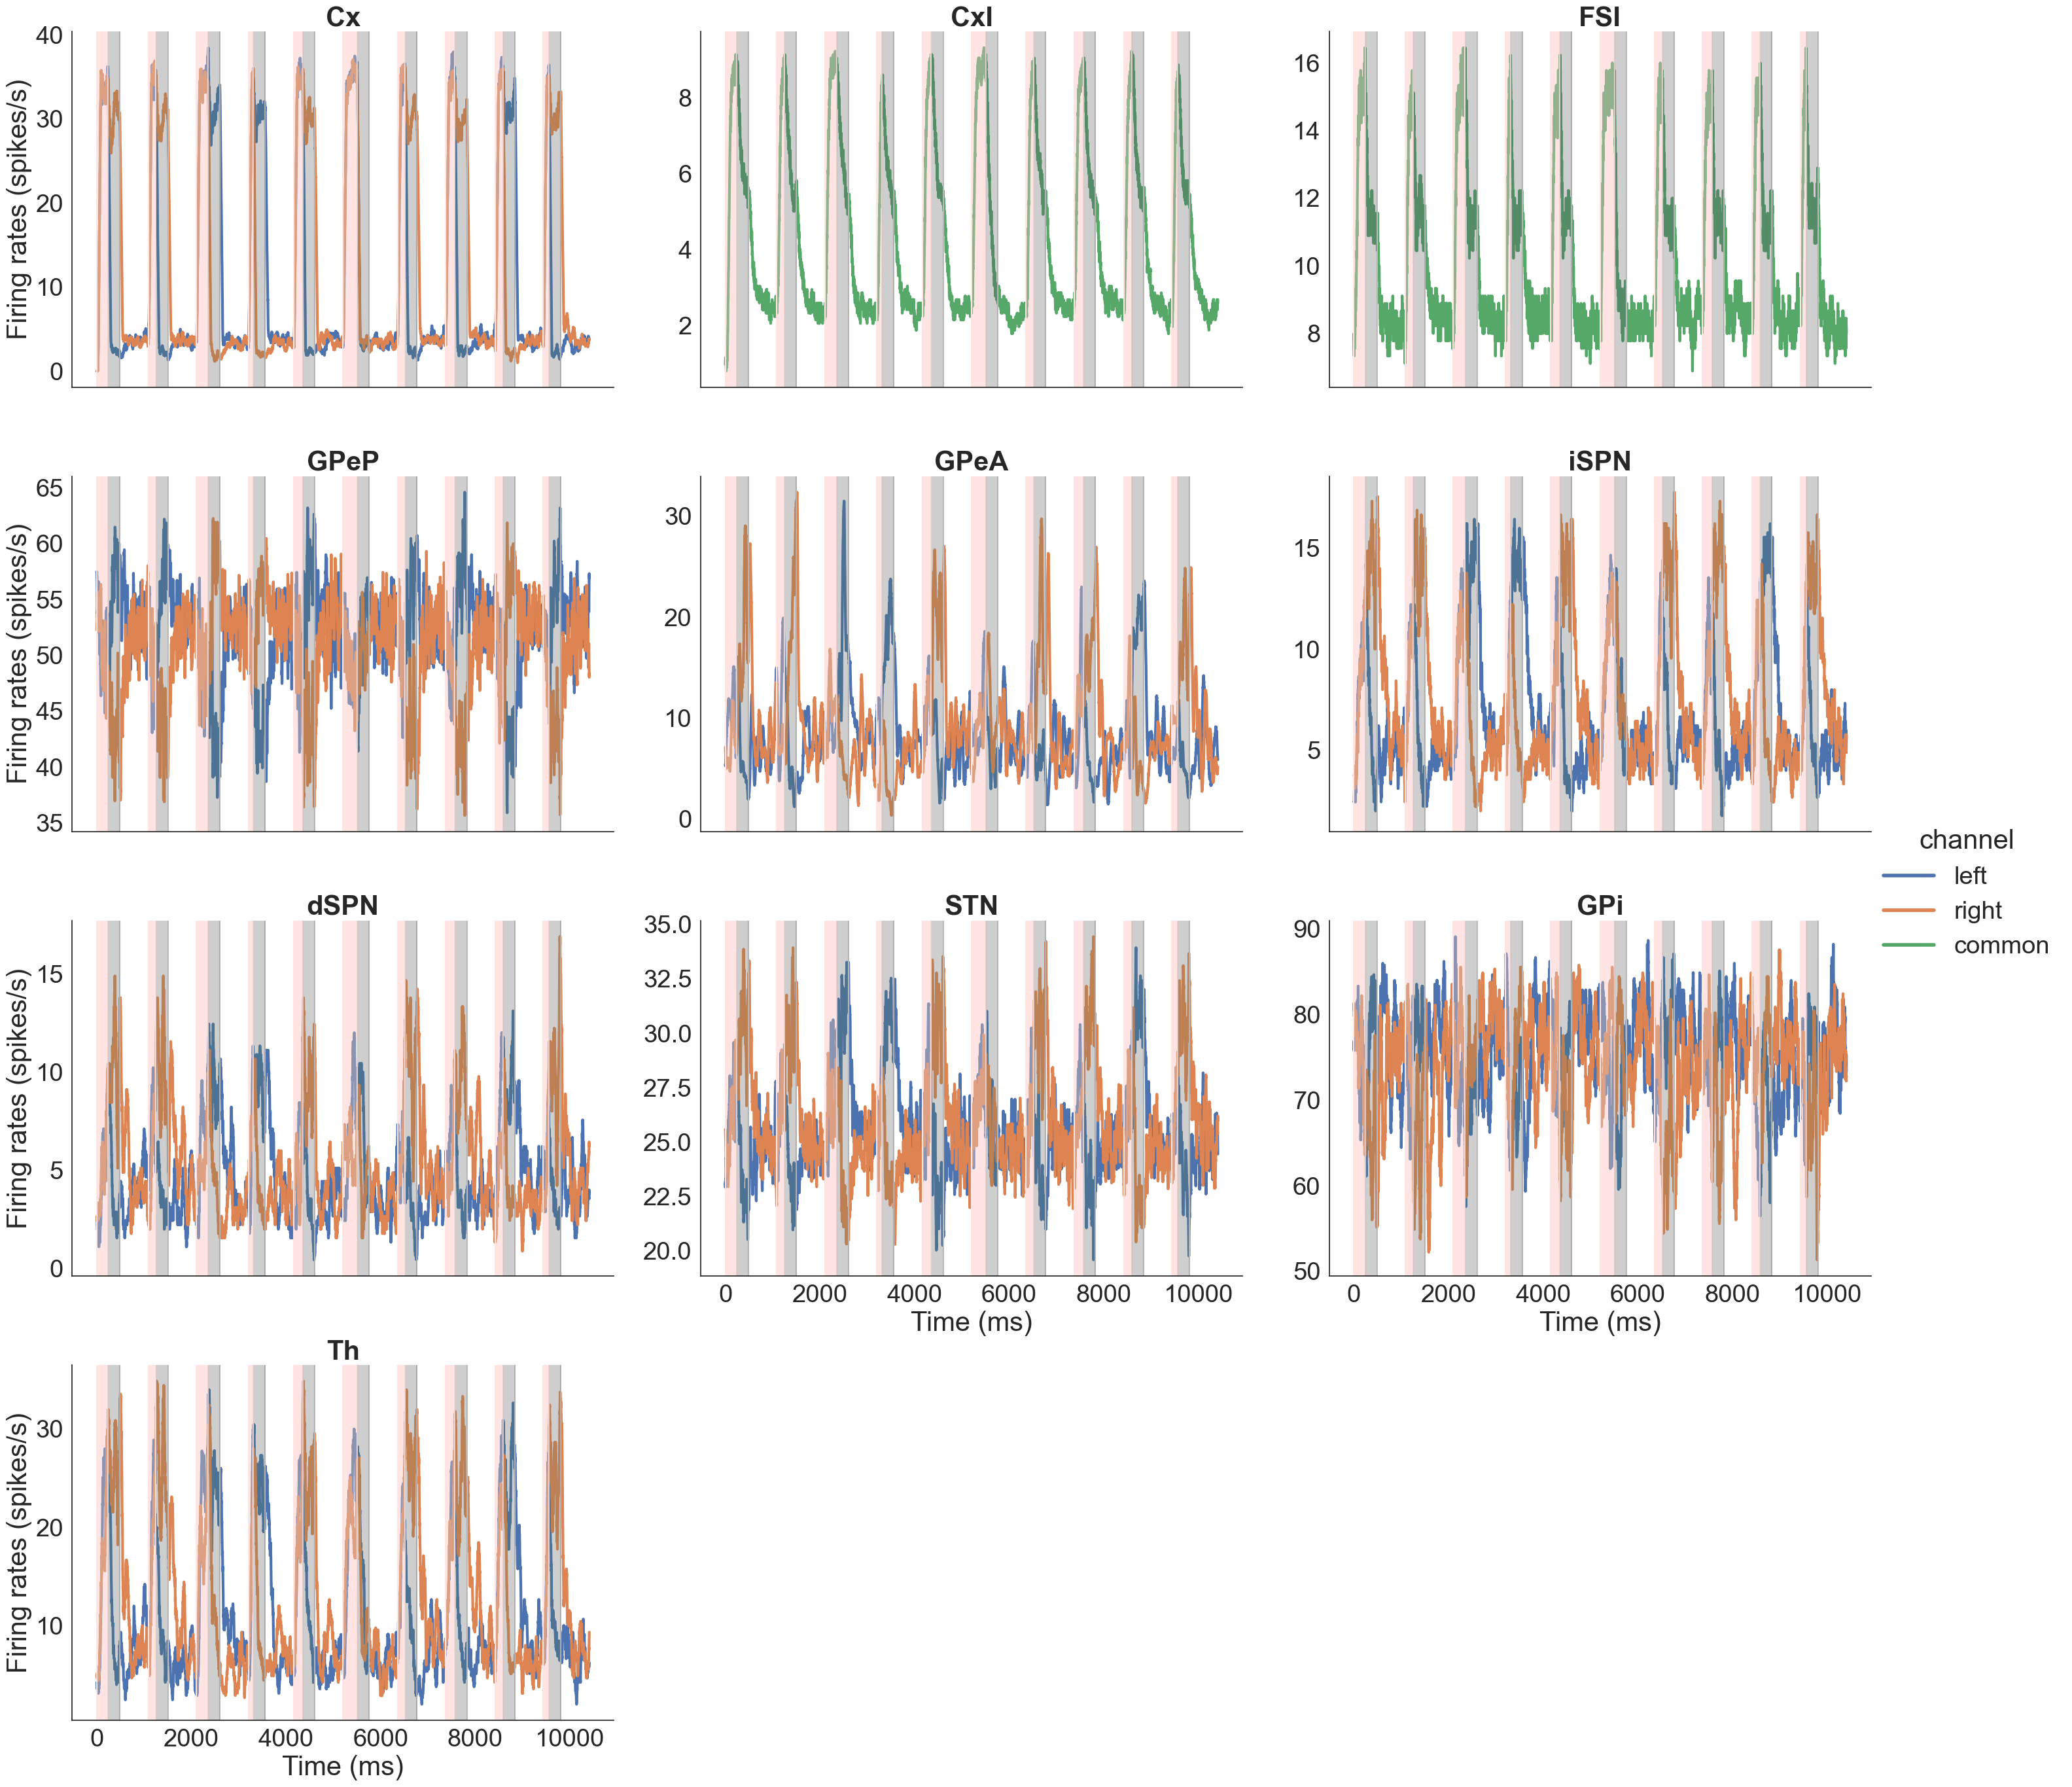

In [29]:
FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_stopsignal_off.png",dpi=300)